# Finding Support and Resitance levels

Support and resitance levels (SRL) are important price levels at which the price of a stock might bounce or in some cases penetrate leading to a change in sentiment that may fuel a new trend. SRLs can be horizontal, but may also be diagonal. The latter are also known as trendlines. These will be investigated in the next post. Finding horizontal SRLs is usually done manually by finding price reversal points and then connecting these points using a line. Humans are quite good at drawing lines connecting points as we can see what points are important and which ones are not. Machines have a more difficult time understanding this.

After identification, SRLs may be used in trading in a number of different ways. My favorites are "break out" and "bounce" strategies. The first one buys a stock when the price penetrates an important level. While the second one bets on the price level not being penetrated as the stock bounces on the price level.

In this post, I will evaluate three different techniques that can be used for finding SRLs. These techniques are:

- Volume Profile
- Counting
- K-Means

But first, as always, some importing of libraries.

In [1]:
import pymongo
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab; pylab.rcParams['figure.figsize'] = 20, 15
import mplfinance as mpf
from scipy.signal import argrelextrema
import pandas_ta as ta
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Import data
Now let's import the data from the database and plot the last stock.

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


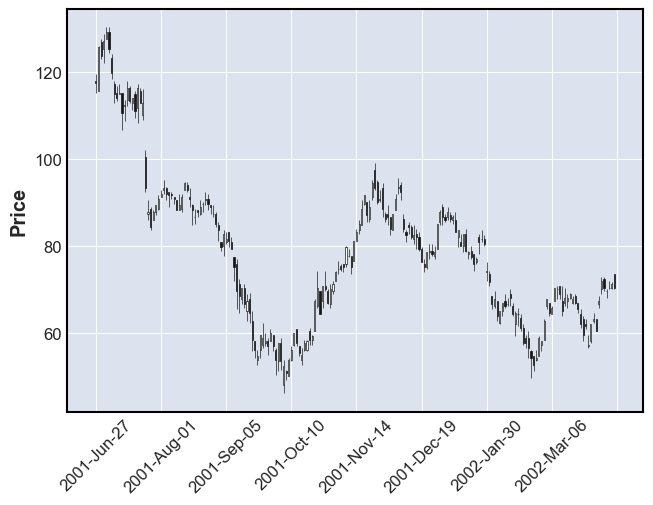

In [2]:
client = pymongo.MongoClient('192.168.1.38', 27017)
daily = client.prod.daily
symbols = [stock["yahoo"] for stock in client.prod.stock_info.find()]
all_dfs = dict()
for symbol in tqdm(symbols[:10]):
    df = pd.DataFrame(daily.find({"symbol":symbols[1]}).sort("date", pymongo.ASCENDING))
    df.set_index("date", inplace=True)
    all_dfs[symbol] = df
mpf.plot(df[:200], type='candle')

# Argrelextrema
First, in order to find SRLs reversal points need to be found. There are many ways of doing this. Popular methods include the [zig-zag indiator](https://www.investopedia.com/terms/z/zig_zag_indicator.asp) or [argrelextrema](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html). The latter will be used in this post. This algorithms deems a point to be a reversal if it is the greatest (or smallest) point withing a window. Essentially, the algorithm compares **n** points before and after the current point. 

The following is what we want, these are reversal points:

In [3]:
df[:200].close.iloc[argrelextrema(df[:200].close.values, np.greater_equal, order=4)[0]].head()

date
2001-07-03    129.2140
2001-07-13    116.4473
2001-07-19    116.4473
2001-08-02     93.2352
2001-08-14     94.3958
Name: close, dtype: float64

Notice that argrelextrama has a parameter called "order". This integer indicates how many points around the current point that should be checked. If this number is large, then only "large reversals" will be found. The opposite is true for small values of "order". Larger values result in fewer reversals.

Now let's plot these reversals together with the stock price. The reversals will be found with order sizes of 4 and 10 respecively.

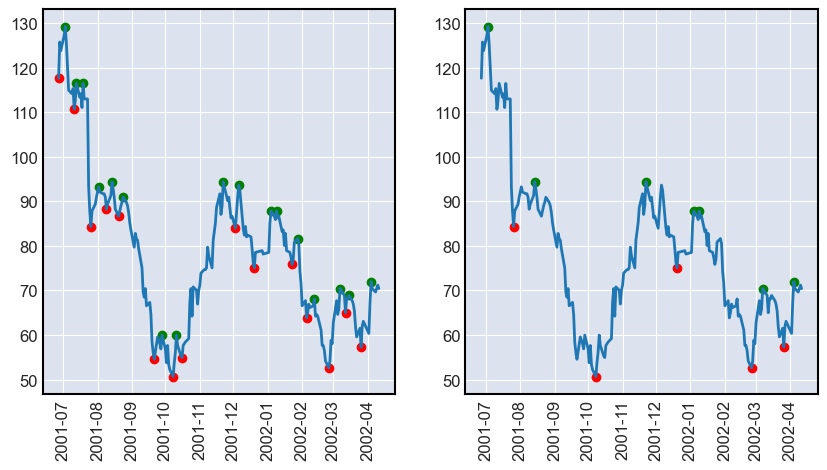

In [4]:
view = df[:200]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, order in zip(axs, [4, 10]):
    peaks = view.close.iloc[argrelextrema(view.close.values, np.greater_equal, order=order)[0]]
    bottoms = view.close.iloc[argrelextrema(view.close.values, np.less_equal, order=order)[0]]
    ax.plot(view.close)
    ax.scatter(peaks.index, peaks, color="g")
    ax.scatter(bottoms.index, bottoms, color="r")
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.show()

As it can be seen, the algorithm finds the peaks and bottoms of the stock price. Notice that around January 2002 the algorithm found multiple tops after each other. If the zig-zag indicator would have been used, then this output would not have been seen. The indicator requires there to be a bottom before a new top.

Note: notice that the point around October 2001 make up a head and should formation. In the coming posts these points will be used to find price action formations such as VCP.

## Getting all the pivots
Just getting reversals for the close price can be useful, but the price might not close at the SRL. Sometimes the touch of the SRL is at the high or low of the day. Therefore, reversals for both the high, low and close have to be found. This is done using the `get_pivots()` function. A list of all prices where the stock reverses is returned. As the price of a stock is quite noisy, the prices are rounded to the closest integer.

The aforementioned function works well, but can be improved by incorporating different values for order. I chose to call this function `multi_scale_pivots()`. One feature of this function is that it weights larger values for order more. This is good as larger reversals are more important than smaller ones. The function does this by featuring the prices of bigger reversals more often (`get_pivots(df, order=n)*(n-min(times))`).

In [5]:
def get_pivots(df, order=4):
    pivots = list()
    pivots += list(df.low.iloc[argrelextrema(df.low.values, np.less_equal, order=order)[0]].values)
    pivots += list(df.high.iloc[argrelextrema(df.high.values, np.greater_equal, order=order)[0]].values)
    pivots += list(df.close.iloc[argrelextrema(df.close.values, np.less_equal, order=order)[0]].values)
    pivots += list(df.close.iloc[argrelextrema(df.close.values, np.greater_equal, order=order)[0]].values)
    pivots = [round(pivot) for pivot in pivots]
    return pivots

def multi_scale_pivots(df, times=range(4, 10)):
    pivots = list()
    for n in times:
        pivots+=get_pivots(df, order=n)*(n-min(times))
    return pivots

print("get_pivots() - length:", len(get_pivots(df[:20])))
print(get_pivots(df[:20]))
print("\nmulti_scale_pivots() - length:", len(multi_scale_pivots(df[:20])))
print(multi_scale_pivots(df[:20]))

get_pivots() - length: 12
[115, 107, 92, 130, 130, 118, 118, 111, 93, 129, 116, 116]

multi_scale_pivots() - length: 118
[115, 107, 92, 130, 130, 118, 118, 111, 93, 129, 116, 116, 115, 107, 92, 130, 130, 118, 111, 93, 129, 116, 115, 107, 92, 130, 130, 118, 111, 93, 129, 116, 107, 92, 130, 130, 111, 93, 129, 116, 107, 92, 130, 130, 111, 93, 129, 116, 107, 92, 130, 130, 111, 93, 129, 116, 107, 92, 130, 130, 111, 93, 129, 116, 107, 92, 130, 130, 111, 93, 129, 116, 107, 92, 130, 130, 111, 93, 129, 116, 107, 92, 130, 130, 111, 93, 129, 116, 92, 130, 130, 93, 129, 116, 92, 130, 130, 93, 129, 116, 92, 130, 130, 93, 129, 116, 92, 130, 130, 93, 129, 116, 92, 130, 130, 93, 129, 116]


The following function has been created to plot the result of the models:

In [6]:
def plot_SR(df, func, size = 150):
    fig, axs = plt.subplots(2,2, figsize=(10, 10))
    axs = axs.reshape(-1)
    for i, ax in enumerate(axs):
        view = df[size*i:size*(1+i)]
        sr = func(view)
        mpf.plot(view, ax = ax, type="candle", hlines={"hlines":list(sr), "alpha":0.3, "colors":["r", "g", "b", "c", "m", "y"]})
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
    plt.show()

# Volume Profile
The first model that is going to be used is based on the [volume profile](https://www.tradingview.com/support/solutions/43000502040-volume-profile/) and has therefore been named such. The "volume" is the number of shares traded on a specific time interval (e.g. per day). See the volume column in the cell below. The volume profile measures the number of shares traded in a price interval. Large volumes at a specific price can indicate SRLs. One explanation might be that during a downward trend seller sell at lower and lower prices. At some point they are not willing to sell for less per share and buyers are stepping in and absorbing the sell pressure. It might take a lot of buying before the sentiment changes and the price changes direction. Therefore, quite some volume might be traded at the reversal price. At a future time, sellers might become buyers are prices which have previously acted as reversal zones. Thusly, even more volume is traded at that price.

The way that this technique is going to be applied is by calculating the volume profile and then choosing the **n** price levels with the highest volume.

In [7]:
df[["open", "high", "low", "close", "volume"]].head(1)

,open,high,low,close,volume
date,,,,,
2001-06-27,117.9948,119.5423,115.2867,117.6079,1088873


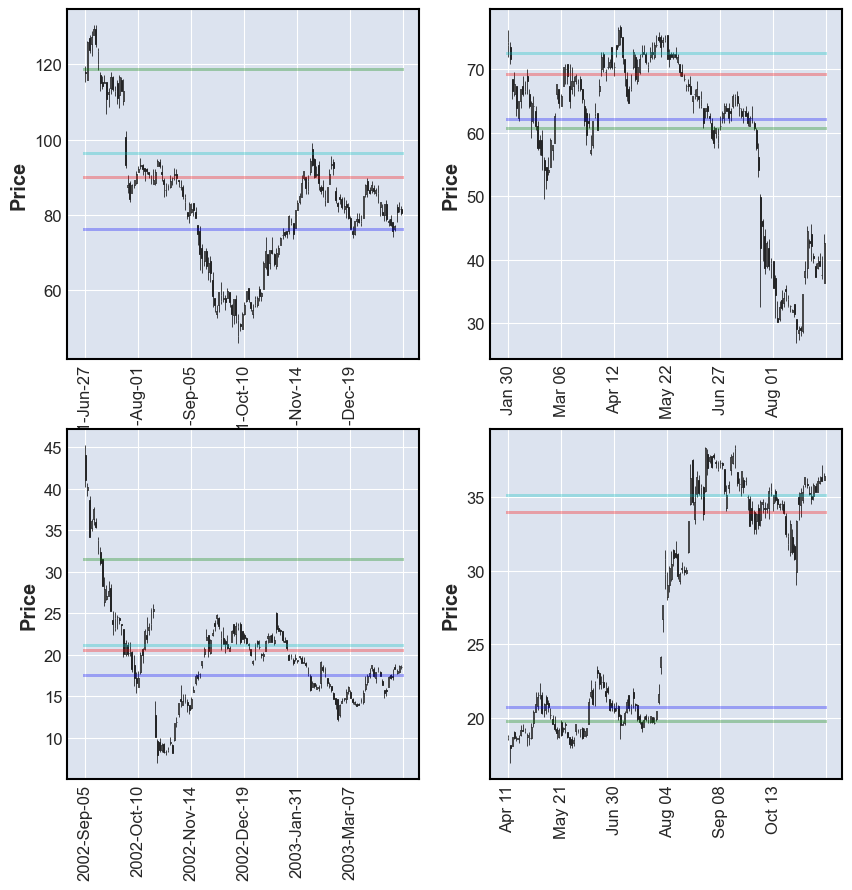

In [8]:
def volume_profile(view, bins = 10, n = 4):
    vp = view.copy().ta.vp(bins)
    sr = vp.iloc[np.argsort(vp["total_volume"])[:n]]["mean_close"]
    return list(sr)

plot_SR(df, volume_profile)

As it can be seen in the plots above, the levels chosen by the algorithm are not always exactly at the reversals. This can be explained by the fact that a lot of volume is also traded in consolidation. Sometimes more than at the reversals. These SRLs are more suitable as reversal zones rather than reversal prices.

# K-Means
The second technique that is going to be evaluated will be named k-means and it uses machine learning to find the center of a cluster of points (for illustration see [video](https://www.youtube.com/watch?v=fGkGRoiBtKg) by Najam Syed). In this case, the points are going to be prices and the centers will be the support and resitance points. This approach was inspired by Karl Tengelin in his [master thesis](https://lup.lub.lu.se/student-papers/search/publication/9008772) in 2020. The difference between the following approach and Tengelin's approach is that he used tick data and in this case daily data will be used.

Following Tengelin's approach, all closing prices are given to the model. The model then tries to find the centers of what hopefully are clusters. This ML model's primary parameter is **k**. The value chosen for this parameter should be chosen such that the [silloute score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) is maximised. The code below was heavily inspired by Suhail Saqan's [blog post](https://medium.com/swlh/using-machine-learning-to-locate-support-and-resistance-lines-for-stocks-461d590e9925).

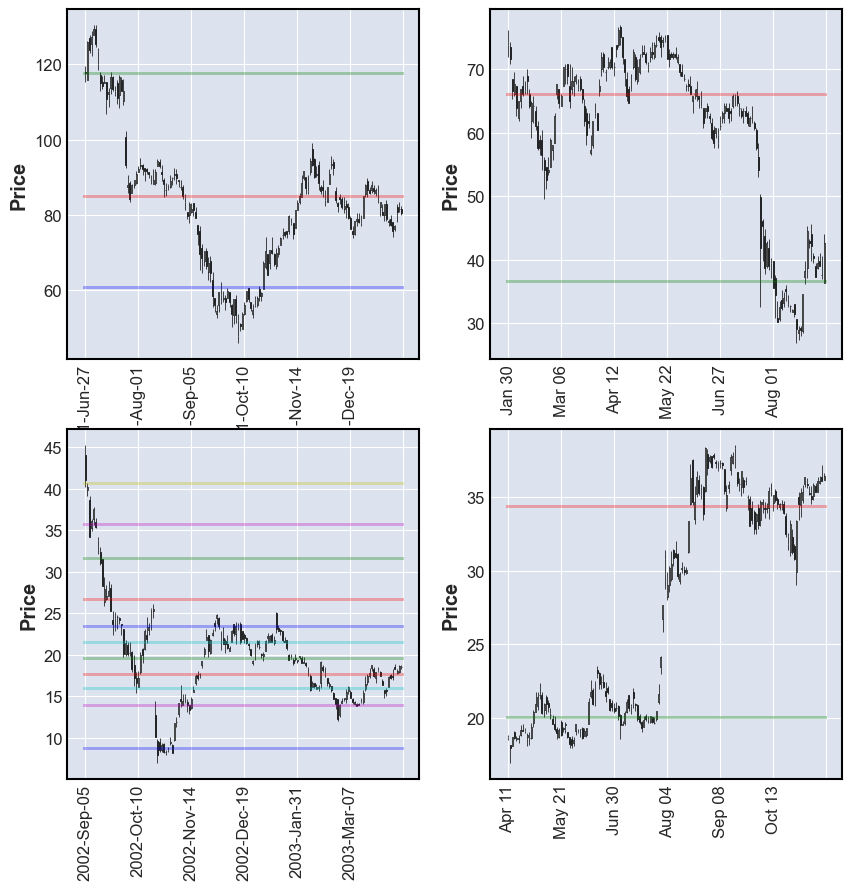

In [9]:
def k_means_all(view):
    def optimum_Kvalue(data):
        kmax = 11
        sil = {}
        k_model = {}
        for k in range(2, kmax+1):
            kmeans = KMeans(n_clusters = k).fit(data)
            k_model[k] = kmeans
            labels = kmeans.labels_
            sil[k]=(silhouette_score(data, labels))
        optimum_cluster = k_model[max(sil, key=sil.get)]
        return optimum_cluster
    
    model = optimum_Kvalue(np.array(view.close).reshape(-1, 1))
    return list(model.cluster_centers_.reshape(-1))
    
plot_SR(df, k_means_all)

The plots above do not look very good. Some have a lot of lines and some have very few. Very few are at SRLs.

One thing that can be optimized is to feed the model the reversals prices and make it cluster these.

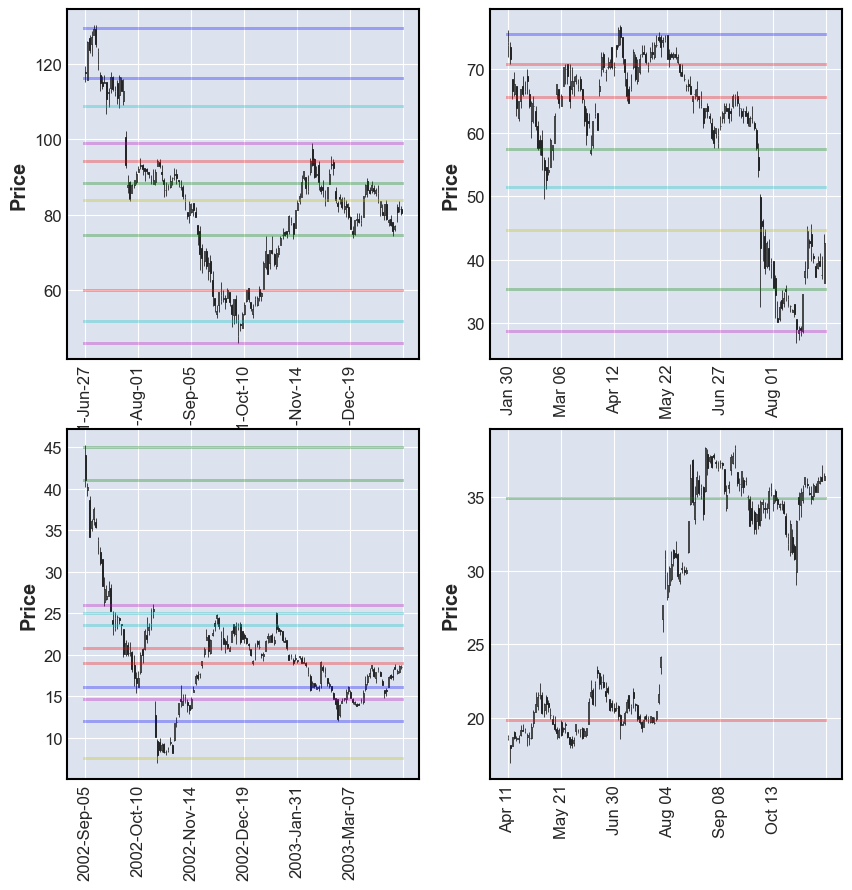

In [10]:
def k_means_reversals(view):
    def optimum_Kvalue(data):
        kmax = 11
        sil = {}
        k_model = {}
        for k in range(2, kmax+1):
            kmeans = KMeans(n_clusters = k).fit(data)
            k_model[k] = kmeans
            labels = kmeans.labels_
            sil[k]=(silhouette_score(data, labels))
        optimum_cluster = k_model[max(sil, key=sil.get)]
        return optimum_cluster
    
    model = optimum_Kvalue(np.array(multi_scale_pivots(view)).reshape(-1, 1))
    return list(model.cluster_centers_.reshape(-1))
plot_SR(df, k_means_reversals)

These results are far better. The model is able to find good SRLs. One drawdown of this model is that the user is not able to tell it how many levels to find. By lowering the value of **k** the performance of the model may be impacted.

# Count
The final method has been named count, because that is what it does. The number of time the price reverses at a price is counted. The higher count the better. This means that the user can chose to plot the **n** best lines by ranking the lines by count.

The following code is used to count:

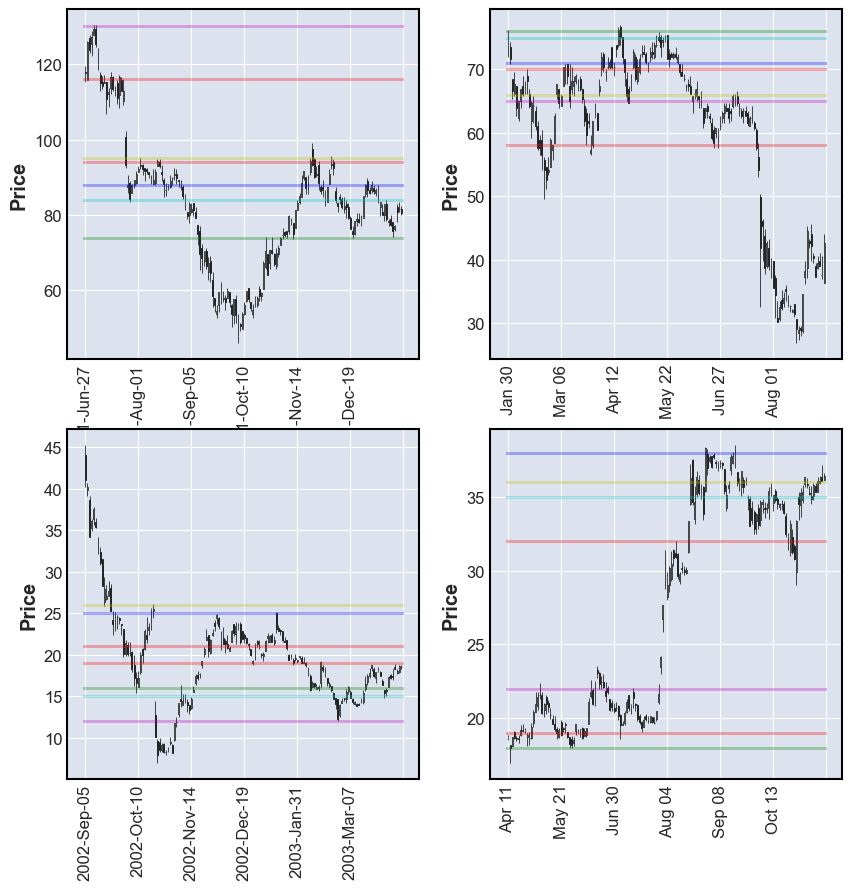

In [11]:
def count(view, n = 7):
    pivots = multi_scale_pivots(view)
    count = Counter(pivots)
    count = {k: v for k, v in sorted(count.items(), key=lambda item: -item[1])}
    return list(count.keys())[:n]

plot_SR(df, count)

This method performes on par with k-means, but has the advantage of ranking the results.

# Comparison
Now the performance of the three methods will be compared. The model's outputs will be plotted together in order to see the difference. However, the figures can seem a little messy as there may in some places be a few lines in very close proximity.

**These are the colors:**
- Volume Profile: RED
- K-means: GREEN
- Count:   BLUE

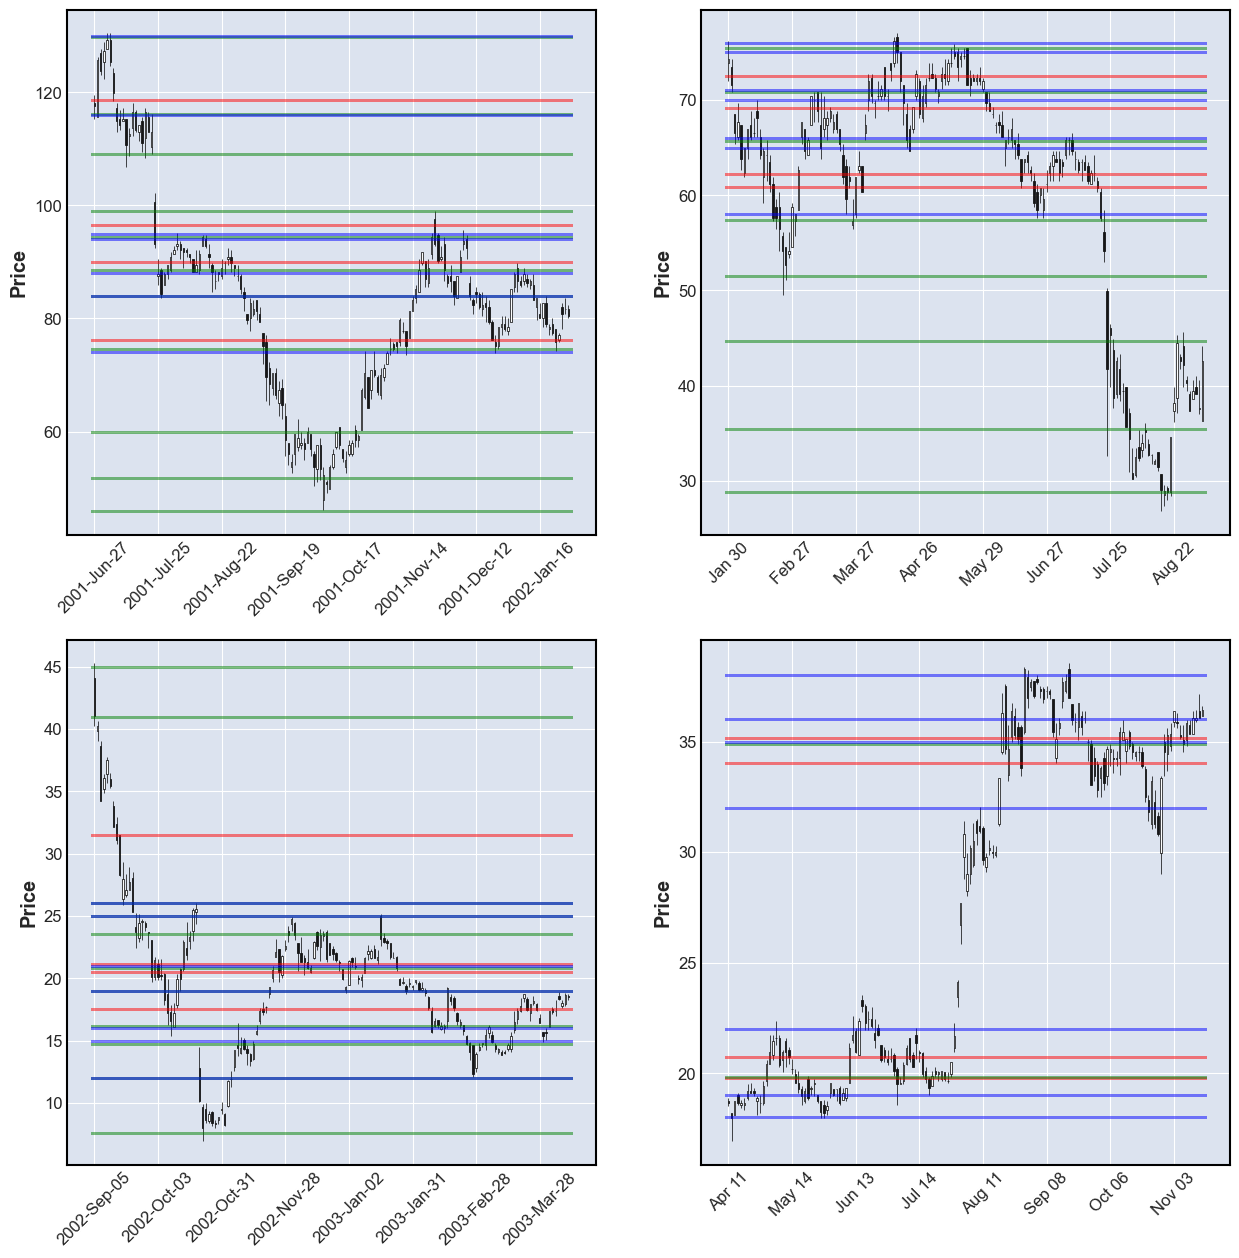

In [12]:
fig, axs = plt.subplots(2,2, figsize=(15, 15))
axs = axs.reshape(-1)
for i, ax in enumerate(axs):
    view = df[150*i:150*(1+i)]
    
    vp = list(volume_profile(view))
    km = list(k_means_reversals(view))
    cn = list(count(view))
    
    mpf.plot(view, ax = ax, type="candle", hlines={"hlines":vp+km+cn, "alpha":0.5, "colors":["r"]*len(vp) + ["g"]*len(km) + ["b"]*len(cn)})
plt.show()

In my opinion, the k-means' SRLs are the best. The problem with the number of lines found can be solved by combining the k-means models with the count model.
This is done by finding labels of all the samples and then sorting the labels from most to least frequently used.

This is the final result:

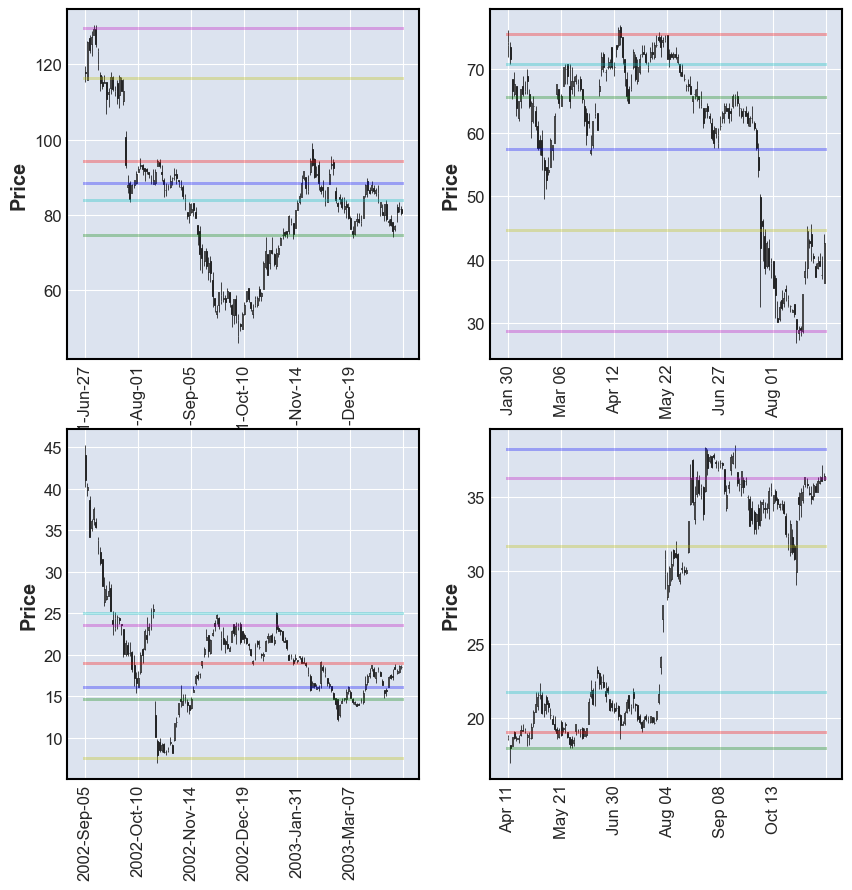

In [16]:
from collections import Counter, defaultdict
def k_means_reversals_count(view, n=6):
    def optimum_Kvalue(data):
        kmax = 11
        sil = {}
        k_model = {}
        for k in range(2, kmax+1):
            kmeans = KMeans(n_clusters = k).fit(data)
            k_model[k] = kmeans
            labels = kmeans.labels_
            sil[k]=(silhouette_score(data, labels))
        optimum_cluster = k_model[max(sil, key=sil.get)]
        return optimum_cluster
    
    model = optimum_Kvalue(np.array(multi_scale_pivots(view)).reshape(-1, 1))
    clusters = model.cluster_centers_.reshape(-1)
    d = dict()
    for label, count in Counter(model.labels_).items():
        d[clusters[label]] = count
    d = {k: v for k, v in sorted(d.items(), key=lambda item: -item[1])}
    return list(d.keys())[:n]

plot_SR(df, k_means_reversals_count)

# In the next post trendline finders will be created!